### Highpass filtering, echo combination
The drifts in the individual echos of the ME data are unfortunately not the same. This becomes an issue when combining the echos: exponential decay functions clearly don't fit if the drifts are uncorrelated (or the T2*-estimates can be biased greatly).

Therefore, apply a highpass filter to the individual echos *before* combination. The argumentation behind this step is that BOLD-responses have a much higher frequency than these slow drifts. Variability removed from the echos by highpass filtering (at 1/128 Hz) can therefore not be caused by BOLD-responses.

In [1]:
import nilearn
import nistats
import os
import pandas
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pprint import pprint
from nilearn.input_data import NiftiMasker
from nilearn.signal import butterworth
import json

from nilearn import plotting
%matplotlib inline

/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/plotting/__init__.py:20: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')
/home/stevenm/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Echo combination without highpass filtering
Makes use of the "optimal combination" method (Posse et al., 1999)

In [2]:
def combine_tedana(tes, data, combmode='t2s', mask=None, overwrite=False, verbose=False):
    """ Function based on tedana main workflow for fast combination of echos """
    from tedana import utils, model, io, decay, combine
    from scipy import stats
    import numpy as np
    import os
    
    # ensure tes are in appropriate format
    tes = [float(te) for te in tes]
    n_echos = len(tes)

    # coerce data to samples x echos x time array
    if isinstance(data, str):
        data = [data]

    if verbose:
        print('Starting to load data...', end='')
    catd, ref_img = io.load_data(data, n_echos=n_echos)
    n_samp, n_echos, n_vols = catd.shape
    if verbose:
        print('success')
    
    if verbose:
        print('Making adaptive mask...', end='')
    mask, masksum = utils.make_adaptive_mask(catd, mask=mask, minimum=False, getsum=True)
    if verbose:
        print('success')

    # check if the t2s-map is already created first
    base_name = data[0].replace('_echo-1', '_%s').replace('.nii', '').replace('.gz', '')
    if not os.path.exists(base_name %'t2sv' + '.nii.gz') or overwrite:
        if verbose:
            print('Fitting decay...', end='')
        t2s, s0, t2ss, s0s, t2sG, s0G, residuals_limited, residualss, residuals_full = decay.fit_decay(catd, tes, mask, masksum, return_residuals=True)
        if verbose:
            print('success')

            
        # set a hard cap for the T2* map
        # anything that is 10x higher than the 99.5 %ile will be reset to 99.5 %ile
        if verbose:
            print('Setting cap on t2star...', end='')
        cap_t2s = stats.scoreatpercentile(t2s.flatten(), 99.5,
                                          interpolation_method='lower')
        t2s[t2s > cap_t2s * 10] = cap_t2s
        if verbose:
            print('success')
        
        # save
        print('Starting saving...', end='')
        io.filewrite(t2s, base_name %'t2sv' + '.nii', ref_img, gzip=True)
        print('t2s done..', end='')
        io.filewrite(s0, base_name %'s0v' + '.nii', ref_img, gzip=True)
        print('s0v done..', end='')
        io.filewrite(t2ss, base_name %'t2ss' + '.nii', ref_img, gzip=True)
        print('t2ss done..', end='')
        io.filewrite(s0s, base_name %'s0vs' + '.nii', ref_img, gzip=True)
        print('s0vs done..', end='')
        io.filewrite(t2sG, base_name %'t2svG' + '.nii', ref_img, gzip=True)
        print('t2svG done..', end='')
        io.filewrite(s0G, base_name %'s0vG' + '.nii', ref_img, gzip=True)
        print('s0vG done..', end='')
        io.filewrite(residuals_limited, base_name %'residualsv' + '.nii', ref_img, gzip=True)
        print('residualsv done..', end='')
        io.filewrite(residualss, base_name %'residualss' + '.nii', ref_img, gzip=True)
        print('residualss done..', end='')
        io.filewrite(residuals_full, base_name %'residualsvG' + '.nii', ref_img, gzip=True)
        print('residualsvG done..', end='')
    else:
        t2sG = utils.load_image(base_name %'t2svG' + '.nii.gz')
        t2s = utils.load_image(base_name %'t2sv' + '.nii.gz')
        
    # optimally combine data
    if verbose:
        print('Starting combination...', end='')
    data_oc = combine.make_optcom(catd, tes, mask, t2s=t2sG, combmode=combmode)
    if combmode == 't2s':
        ext = 'optcomb'
    else:
        ext = 'PAID'
    print('Combined, writing results...')
    
    # make sure to set all nan-values/inf to 0
    data_oc[np.isinf(data_oc)] = 0
    data_oc[np.isnan(data_oc)] = 0
    io.filewrite(data_oc, base_name %ext + '.nii', ref_img, gzip=True)

In [3]:
# find echo times
tes = []
for echo_n in np.arange(1,4):
    with open('./data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-%d_bold.json'%echo_n, 'r') as f:
        tes.append(float(json.load(f)['EchoTime']))
tes

[0.00966, 0.02487, 0.04008]

In [4]:
import multiprocessing as mp
from functools import partial

def multiproc_help_func(run, sub, tes, hp, echo_template):
    sub_str = str(sub).zfill(2)
    echos = [echo_template.format(**{'sub': sub_str, 'run': run, 'echo': x, 'hp': '_hp' if hp else ''}) for x in np.arange(1,4)]
    if hp:
        mask = echos[0].replace('_preproc_hp.nii.gz', '_brainmask.nii.gz')
    else:
        mask = echos[0].replace('_preproc.nii.gz', '_brainmask.nii.gz')
    
    # check if residuals file exists yet
    if os.path.exists(echos[0].replace('echo-1', 'residualsvG')):
        print('%s %d already exists' %(sub_str, run))
        return 0
#     fn_resid = 'sub-01_ses-me_task-stop_run-3_residualsvG_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'
#         print(mask)
    combine_tedana(tes, echos, mask=mask, overwrite=True, verbose=True)

In [5]:
echo_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_echo-{echo}_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'
hp = True
for sub in np.arange(1, 19):
    if sub == 12:
        continue # no ses-me for sub 12
    
    sub_str = str(sub).zfill(2)
    runs = [1,2,3]
    
    with mp.Pool(3) as p:
        p.map(partial(multiproc_help_func, sub=sub, tes=tes, hp=hp, echo_template=echo_template), runs)


#     for run in [1,2,3]:
#         print('Sub {}, run {}...'.format(sub_str, run), end='')
#         echos = [echo_template.format(**{'sub': sub_str, 'run': run, 'echo': x}) for x in np.arange(1,4)]
#         mask = echos[0].replace('_preproc.nii.gz', '_brainmask.nii.gz')
# #         print(mask)
#         combine_tedana(tes, echos, mask=mask, overwrite=True, verbose=True)

/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Iterator
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/io.py:18

Starting to load data...success
Starting to load data...success
Making adaptive mask...success
Making adaptive mask...success
Starting to load data...success
Making adaptive mask...success


/home/stevenm/miniconda3/lib/python3.7/site-packages/tedana/decay.py:98: RuntimeWarning: divide by zero encountered in true_divide
  t2s = 1. / betas[1, :].T
/home/stevenm/miniconda3/lib/python3.7/site-packages/tedana/decay.py:98: RuntimeWarning: divide by zero encountered in true_divide
  t2s = 1. / betas[1, :].T
/home/stevenm/miniconda3/lib/python3.7/site-packages/tedana/decay.py:98: RuntimeWarning: divide by zero encountered in true_divide
  t2s = 1. / betas[1, :].T


Fitting decay...success


/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Setting cap on t2star...success
Fitting decay...success


/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Setting cap on t2star...success
Fitting decay...success


/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Setting cap on t2star...success


/home/stevenm/miniconda3/lib/python3.7/site-packages/tedana/combine.py:35: RuntimeWarning: divide by zero encountered in true_divide
  alpha = tes * np.exp(-tes / ft2s)
/home/stevenm/miniconda3/lib/python3.7/site-packages/tedana/combine.py:35: RuntimeWarning: divide by zero encountered in true_divide
  alpha = tes * np.exp(-tes / ft2s)
/home/stevenm/miniconda3/lib/python3.7/site-packages/tedana/combine.py:35: RuntimeWarning: divide by zero encountered in true_divide
  alpha = tes * np.exp(-tes / ft2s)


Starting saving...t2s done..s0v done..t2ss done..s0vs done..t2svG done..s0vG done..residualsv done..residualss done..residualsvG done..Starting combination...Combined, writing results...
Starting saving...t2s done..s0v done..t2ss done..s0vs done..t2svG done..s0vG done..residualsv done..residualss done..residualsvG done..Starting combination...Combined, writing results...
Starting saving...t2s done..s0v done..t2ss done..s0vs done..t2svG done..s0vG done..residualsv done..residualss done..residualsvG done..Starting combination...Combined, writing results...


/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Iterator
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/io.py:18

Starting to load data...success
Making adaptive mask...success
Starting to load data...success
Starting to load data...success
Making adaptive mask...success
Making adaptive mask...success


KeyboardInterrupt: 

### Inspect the extent of the problem: Where does monoexponential decay misfit?

In [ ]:
#!ls ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz

In [7]:
roi = './masks/final_masks_mni09a_1p6mm/STN_R_def-img.nii.gz'
from nilearn.plotting import find_xyz_cut_coords

def add_contours(disp, roi, thr=0.3, linewidth=1, color='white', **kwargs):
    from nilearn._utils.extmath import fast_abs_percentile
    from nilearn._utils.param_validation import check_threshold
    
    map_img = nib.load(roi)
    data = map_img.get_data()
    
    # threshold manually
    thr = check_threshold(thr, data,
                          percentile_func=fast_abs_percentile,
                          name='threshold')
    
    # Get rid of background values in all cases
    thr = max(thr, 1e-6)
    if data.max() > 1:
        thr = thr*100
    disp.add_contours(roi, levels=[thr], linewidth=linewidth, colors=[color], **kwargs)

/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


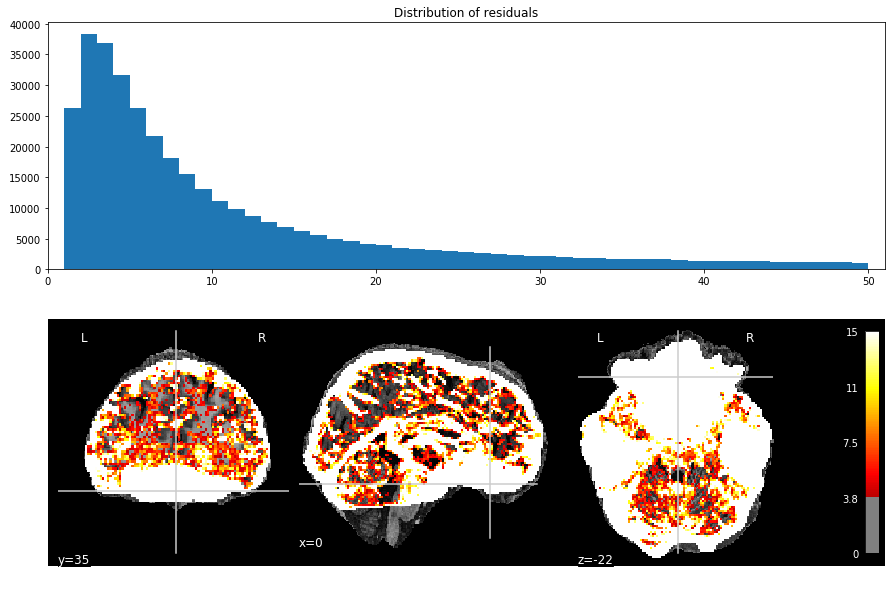

In [31]:
sub = 1
sub_str = str(sub).zfill(2)
run = 1
hp = False
residuals_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_residualsvG_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'
t1w_template = './data/deriv/fmriprep/sub-{sub}/anat/sub-{sub}_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'
# def make_median_img(hdr):
#     if isinstance(hdr, str):
#         hdr = nib.load(hdr)
#     dat = np.median(hdr.get_data(), axis=3)
#     return nib.Nifti1Image(dat, hdr.affine)

# median_residuals = make_median_img(residuals_template.format(**{'sub': sub_str, 'run': run}))
median_residuals = nib.load(residuals_template.format(**{'sub': sub_str, 'run': run, 'hp': '_hp' if hp else ''}))
f, ax = plt.subplots(2,1)
ax[0].hist(median_residuals.get_data().ravel(), bins=np.arange(1,51))
ax[0].set_xlim(0, 51)
ax[0].set_title('Distribution of residuals')

#cut_coords = find_xyz_cut_coords(roi)
cut_coords = [0, 35, -22]
disp = plotting.plot_stat_map(median_residuals, bg_img=t1w_template.format(**{'sub':sub_str}), 
                              axes=ax[1], draw_cross=True, 
                              cut_coords=cut_coords,
                              vmax=15, threshold=4)
add_contours(disp, roi, color='purple')
plt.gcf().set_size_inches(15, 10)

#### So the monoexponential decay fit is relatively bad in STN ("it is white") - but how bad is "relatively" bad?
Let's visualize, extract timecourse of center of mass voxel in STN from individual echos

In [25]:
# find STN_R center of mass in matrix
from nibabel.affines import apply_affine
from numpy.linalg import pinv
cut_coords_matrix_space = apply_affine(pinv(median_residuals.affine), cut_coords).astype(int)
echo_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_echo-{echo}_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'

echo_fns = [echo_template.format(**{'sub': str(sub).zfill(2), 'run': 1, 'echo': x, 'hp': ''}) for x in [1,2,3]]
# extract timeseries...
ts = [nib.load(echo_fns[x]).get_data()[cut_coords_matrix_space[0],cut_coords_matrix_space[1],cut_coords_matrix_space[2],:] for x in range(3)]
ts_optcomb = nib.load(echo_fns[0].replace('echo-1', 'optcomb')).get_data()[cut_coords_matrix_space[0],cut_coords_matrix_space[1],cut_coords_matrix_space[2],:]

In [26]:
cut_coords_matrix_space

array([ 61, 105,  31])

In [29]:
def fit_decay_simple(data, tes):
    from tedana import utils
    n_samp = data.shape[0]
    n_echos = data.shape[1]
    n_vols = data.shape[2]
    t2ss = np.zeros([n_samp, n_echos - 1])
    s0vs = np.zeros([n_samp, n_echos - 1])
    residualss = np.zeros([n_samp, n_echos - 1])

    for echo in range(n_echos-1, n_echos):
        # perform log linear fit of echo times against MR signal
        # make DV matrix: samples x (time series * echos)
        log_data = np.log((np.abs(data[:, :echo+1, :]) + 1).reshape(len(data), -1).T)
        # make IV matrix: intercept/TEs x (time series * echos)
        x = np.column_stack([np.ones(echo+1), [-te for te in tes[:echo+1]]])
        X = np.repeat(x, n_vols, axis=0)

        fit = np.linalg.lstsq(X, log_data, rcond=None)
        betas = fit[0]
        if echo == 1:
            # first echo has no residuals (perfect fit)
            residuals = np.zeros_like(betas[0, :])
        else:
            residuals = fit[1]
        t2s = 1. / betas[1, :].T
        s0 = np.exp(betas[0, :]).T

        t2s[np.isinf(t2s)] = 500.  # why 500?
        s0[np.isnan(s0)] = 0.      # why 0?
    
    return s0, t2s, residuals

In [27]:
s0_t2star_residuals = np.empty((ts[0].shape[-1], 3))
for vol in np.arange(ts[0].shape[-1]):
    s0_t2star_residuals[vol,...] = fit_decay_simple(data = np.hstack([ts])[np.newaxis,:,vol,np.newaxis], tes=tes)

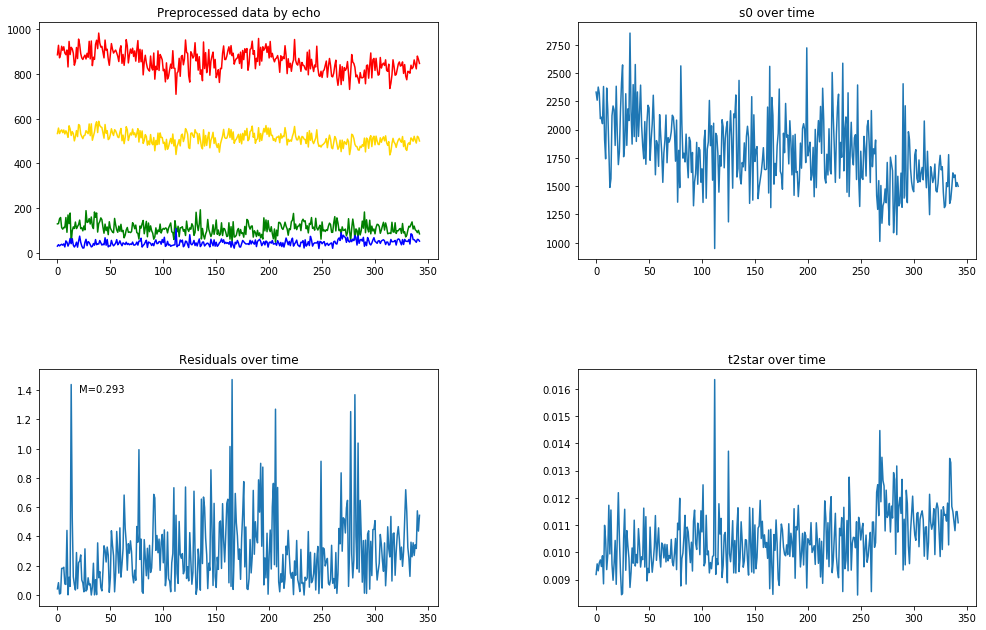

In [28]:
f, ax = plt.subplots(2,2)
ax[0,0].plot(ts[0], color='red')
ax[0,0].plot(ts[1], color='green')
ax[0,0].plot(ts[2], color='blue')
ax[0,0].plot(ts_optcomb, color='gold')
ax[0,0].set_title('Preprocessed data by echo')

ax[1,0].plot(s0_t2star_residuals[:,-1])
ax[1,0].set_title('Residuals over time')
ax[1,0].text(0.1, 0.9, 'M=%.3f' %s0_t2star_residuals[:,-1].mean(), transform=ax[1,0].transAxes)

ax[0,1].plot(s0_t2star_residuals[:,0])
ax[0,1].set_title('s0 over time')

ax[1,1].plot(s0_t2star_residuals[:,1])
ax[1,1].set_title('t2star over time')
f.tight_layout()
f.set_size_inches(15,10)

In [186]:
# Same voxel, but now *highpassed*

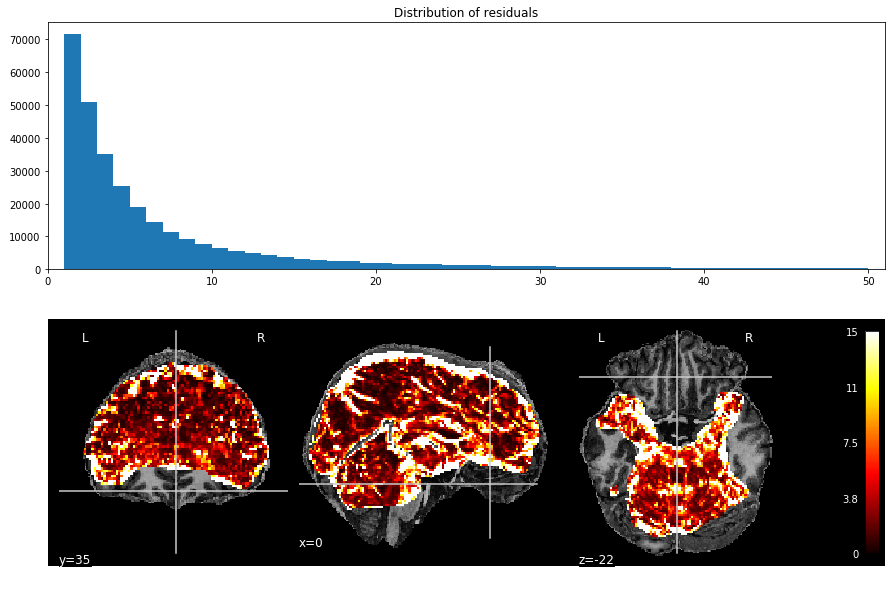

In [32]:
sub = 1
sub_str = str(sub).zfill(2)
run = 1
hp = True
residuals_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_residualsvG_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'
t1w_template = './data/deriv/fmriprep/sub-{sub}/anat/sub-{sub}_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'
# def make_median_img(hdr):
#     if isinstance(hdr, str):
#         hdr = nib.load(hdr)
#     dat = np.median(hdr.get_data(), axis=3)
#     return nib.Nifti1Image(dat, hdr.affine)

# median_residuals = make_median_img(residuals_template.format(**{'sub': sub_str, 'run': run}))
median_residuals = nib.load(residuals_template.format(**{'sub': sub_str, 'run': run, 'hp': '_hp' if hp else ''}))
f, ax = plt.subplots(2,1)
ax[0].hist(median_residuals.get_data().ravel(), bins=np.arange(1,51))
ax[0].set_xlim(0, 51)
ax[0].set_title('Distribution of residuals')

#cut_coords = find_xyz_cut_coords(roi)
disp = plotting.plot_stat_map(median_residuals, bg_img=t1w_template.format(**{'sub':sub_str}), 
                              axes=ax[1], draw_cross=True, cut_coords=cut_coords,
                              vmax=15, threshold=0)
add_contours(disp, roi, color='purple')
plt.gcf().set_size_inches(15, 10)

### Where did orbitofrontal cortex go?
Well, it disappeared, because the last echo has no signal. As a result, you're fitting a line between two points, which always works: you overfit massively, leading to *no residuals*

In [33]:
# find STN_R center of mass in matrix
from nibabel.affines import apply_affine
from numpy.linalg import pinv
cut_coords_matrix_space = apply_affine(pinv(median_residuals.affine), cut_coords).astype(int)
echo_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_echo-{echo}_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'

echo_fns = [echo_template.format(**{'sub': str(sub).zfill(2), 'run': 1, 'echo': x, 'hp': '_hp' if hp else ''}) for x in [1,2,3]]
# extract timeseries...
ts = [nib.load(echo_fns[x]).get_data()[cut_coords_matrix_space[0],cut_coords_matrix_space[1],cut_coords_matrix_space[2],:] for x in range(3)]
ts_optcomb = nib.load(echo_fns[0].replace('echo-1', 'optcomb')).get_data()[cut_coords_matrix_space[0],cut_coords_matrix_space[1],cut_coords_matrix_space[2],:]

In [34]:
s0_t2star_residuals = np.empty((ts[0].shape[-1], 3))
for vol in np.arange(ts[0].shape[-1]):
    s0_t2star_residuals[vol,...] = fit_decay_simple(data = np.hstack([ts])[np.newaxis,:,vol,np.newaxis], tes=tes)

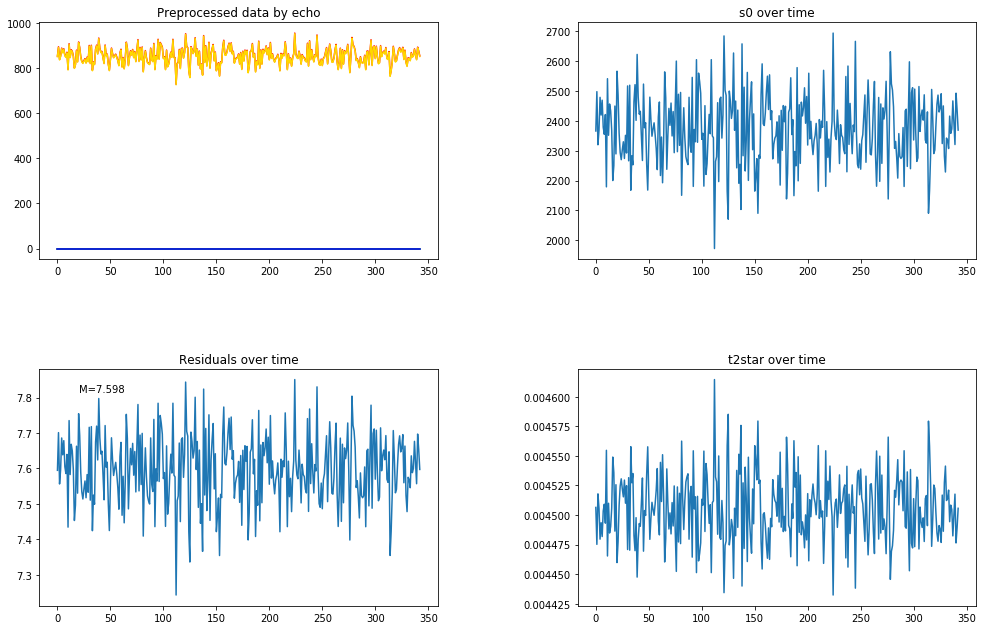

In [35]:
f, ax = plt.subplots(2,2)
ax[0,0].plot(ts[0], color='red')
ax[0,0].plot(ts[1], color='green')
ax[0,0].plot(ts[2], color='blue')
ax[0,0].plot(ts_optcomb, color='gold')
ax[0,0].set_title('Preprocessed data by echo')

ax[1,0].plot(s0_t2star_residuals[:,-1])
ax[1,0].set_title('Residuals over time')
ax[1,0].text(0.1, 0.9, 'M=%.3f' %s0_t2star_residuals[:,-1].mean(), transform=ax[1,0].transAxes)

ax[0,1].plot(s0_t2star_residuals[:,0])
ax[0,1].set_title('s0 over time')

ax[1,1].plot(s0_t2star_residuals[:,1])
ax[1,1].set_title('t2star over time')
f.tight_layout()
f.set_size_inches(15,10)

### So why is the optimally combined signal identical to the first echo signal?
This is because the t2star estimates are *extremely short* (~4ms). As a consequence, only the first echo is really weighted in the procedure. But this is OK (I think)
Note though that the residuals are high (>7) - even after highpassing? (huh? how can this be?)

In [28]:
np.percentile(median_residuals.get_data().ravel(), 95)

34.0075045026673

In [6]:
def highpass_img(fn, hp=1/128., mask=None):
    """ Function used to apply highpass filter """
    if isinstance(fn, str):
        hdr = nib.load(fn)
    else:
        print('Please provide a filename (not a header)')
        return 1
    
    masker = NiftiMasker(mask_img=mask)
    X = masker.fit_transform(hdr)

    t_r = 3.
    X_filtered = butterworth(signals=X, sampling_rate=1./t_r, high_pass=hp, copy=True)  # HP filter at 1/128
    X_filtered = X_filtered + X.mean(0)  # add back mean signal
    fmri_filtered = masker.inverse_transform(X_filtered)
    fmri_filtered.to_filename(fn.replace('.nii.gz', '_hp.nii.gz'))  # save

    return fn.replace('.nii.gz', '_hp.nii.gz')


In [1]:
from nilearn.signal import clean

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

space = 'mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm' # or mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm
bids_root = './data/deriv/fmriprep'
me_template = 'sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-%d_echo-%d_bold_space-'+space+'_preproc.nii.gz'# %(sub, sub, run, echo)
me_mask_template = 'sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-%d_echo-%d_bold_space-'+space+'_brainmask.nii.gz'
se_template = 'sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_space-'+space+'_preproc.nii.gz' # %(sub, sub, run)
se_mask_template = 'sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_space-'+space+'_brainmask.nii.gz'

for sub in range(1, 19):
    print('\nSubject %d, '%sub, end='')
    sub = str(sub).zfill(2)
    
    for run in [1,2,3]:
        # SE first
        print('run %d, se...' %run, end='')
        fn = os.path.join(bids_root, se_template %(sub,sub,run))
        mask = os.path.join(bids_root, se_mask_template %(sub,sub,run))
        if not os.path.exists(fn.replace('.nii.gz', '_hp.nii.gz')):
            _ = highpass_img(fn, mask=mask, hp=1/128.)
        
        if sub == '12':
            continue

        for echo in [1,2,3]:
           
            print(' me echo %d...' %echo, end='')
            # ME here
            fn = os.path.join(bids_root, me_template %(sub,sub,run,echo))
            mask = os.path.join(bids_root, me_mask_template %(sub,sub,run,echo))
            if not os.path.exists(fn.replace('.nii.gz', '_hp.nii.gz')):
                _ = highpass_img(fn, mask=mask, hp=1/128.)


Subject 1,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 2,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 3,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 4,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 5,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 6,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 7,  me echo 1...

KeyboardInterrupt: 

In [ ]:
import scipy as sp
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STN_L_def-img.nii.gz').get_data()
com_stn_L = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STN_R_def-img.nii.gz').get_data()
com_stn_R = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]

mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STR_L_def-img.nii.gz').get_data()
com_str_L = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STR_R_def-img.nii.gz').get_data()
com_str_R = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]


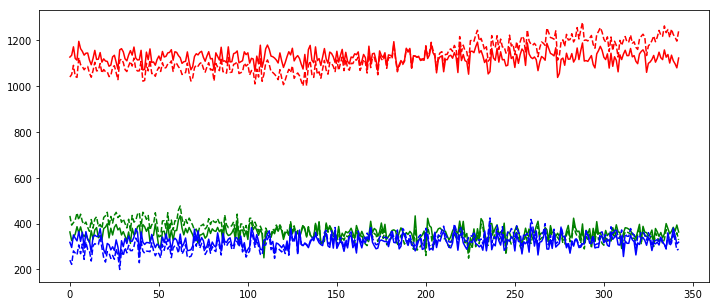

In [48]:
run = 1
cols = ['', 'r', 'g', 'b']
for echo in [1,2,3]:
    fn = './data/deriv/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-stop_run-%d_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz' %(sub, ses, sub, ses, run, echo)

    undetrended_hdr = nib.load(fn)
    detrended_hdr = nib.load(fn.replace('.nii.gz', '_hp.nii.gz'))
    plt.plot(detrended_hdr.get_data()[com_stn_L[0], com_stn_L[1], com_stn_L[2],:], color=cols[echo])
    plt.plot(undetrended_hdr.get_data()[com_stn_L[0], com_stn_L[1], com_stn_L[2],:], linestyle='--', color=cols[echo])
    plt.gcf().set_size_inches(12,5)

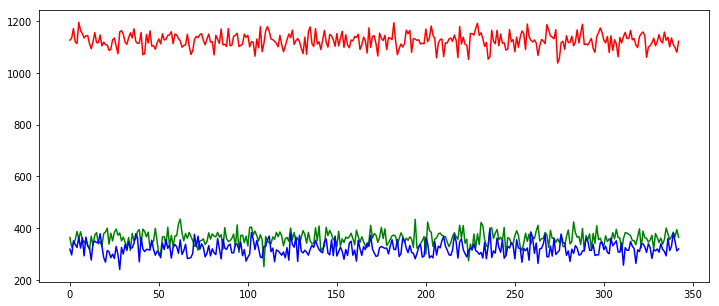

In [49]:
run = 1
cols = ['', 'r', 'g', 'b']
for echo in [1,2,3]:
    fn = './data/deriv/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-stop_run-%d_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz' %(sub, ses, sub, ses, run, echo)

    undetrended_hdr = nib.load(fn)
    detrended_hdr = nib.load(fn.replace('.nii.gz', '_hp.nii.gz'))
    plt.plot(detrended_hdr.get_data()[com_stn_L[0], com_stn_L[1], com_stn_L[2],:], color=cols[echo])
#    plt.plot(undetrended_hdr.get_data()[com_stn_L[0], com_stn_L[1], com_stn_L[2],:], linestyle='--', color=cols[echo])
    plt.gcf().set_size_inches(12,5)

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


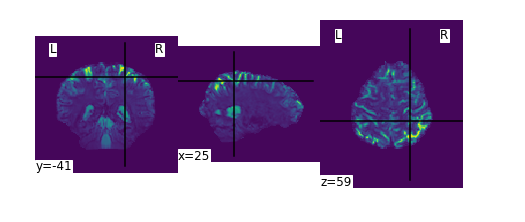

In [45]:
def mean_img(img, axis=3):
    dat = np.mean(img.get_data(), axis=axis)
    img_out = nib.Nifti1Image(dat, img.affine)
    return img_out
    
plotting.plot_img(mean_img(detrended_hdr))